In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=ccc4cf8dba871b08845023e52785e1b67aff308a81940fa13eba9cf57c80d249
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from medmnist import ChestMNIST
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ChestMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 82.8M/82.8M [00:11<00:00, 6.96MB/s]


In [6]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

# Define Critic (Discriminator) for WGAN
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [7]:
# Hyperparameters
latent_dim = 100
lr = 0.00005
epochs = 50
critic_iterations = 5


In [8]:
# Initialize models
generator = Generator(latent_dim).to(device)
critic = Critic().to(device)


In [9]:
# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)


In [10]:
# TensorBoard setup
writer = SummaryWriter("runs/WGAN_training")


In [11]:
# Training Loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Train Critic multiple times per Generator step
        for _ in range(critic_iterations):
            optimizer_C.zero_grad()
            
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z).detach()
            
            c_loss = -torch.mean(critic(real_images)) + torch.mean(critic(fake_images))
            c_loss.backward()
            optimizer_C.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        fake_images = generator(z)
        g_loss = -torch.mean(critic(fake_images))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | C Loss: {c_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    writer.add_scalar("Loss/Generator", g_loss.item(), epoch)
    writer.add_scalar("Loss/Critic", c_loss.item(), epoch)
    
    if (epoch + 1) % 10 == 0:
        torchvision.utils.save_image(fake_images[:16], f"wgan_epoch{epoch+1}.png", nrow=4, normalize=True)
        torch.save(generator.state_dict(), f"generator_epoch{epoch+1}.pth")
        torch.save(critic.state_dict(), f"critic_epoch{epoch+1}.pth")

writer.close()

Epoch [1/50] | C Loss: -28017.6367 | G Loss: 13939.1318
Epoch [2/50] | C Loss: -142262.9062 | G Loss: 185380.4062
Epoch [3/50] | C Loss: -472847.2500 | G Loss: 683624.3750
Epoch [4/50] | C Loss: -599173.0000 | G Loss: 1198374.5000
Epoch [5/50] | C Loss: -1438966.8750 | G Loss: 143841.9375
Epoch [6/50] | C Loss: -737931.6250 | G Loss: -439305.6875
Epoch [7/50] | C Loss: -3656053.7500 | G Loss: 1121974.5000
Epoch [8/50] | C Loss: -8802250.0000 | G Loss: 5026020.0000
Epoch [9/50] | C Loss: -9036933.0000 | G Loss: 6435152.0000
Epoch [10/50] | C Loss: -22913244.0000 | G Loss: -1287476.5000
Epoch [11/50] | C Loss: -19479100.0000 | G Loss: -3090838.0000
Epoch [12/50] | C Loss: -31923926.0000 | G Loss: 26383712.0000
Epoch [13/50] | C Loss: -39313440.0000 | G Loss: 16573891.0000
Epoch [14/50] | C Loss: -86836464.0000 | G Loss: 57857124.0000
Epoch [15/50] | C Loss: -71550464.0000 | G Loss: 37857608.0000
Epoch [16/50] | C Loss: -95758064.0000 | G Loss: 52924096.0000
Epoch [17/50] | C Loss: -11771

In [16]:
test_dataset = ChestMNIST(split='test', transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)


Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [17]:
real_images_test = []
for images, _ in test_dataloader:
    real_images_test.append(images)
real_images_test = torch.cat(real_images_test, dim=0)[:100]  
real_images_test = real_images_test.to(device)

In [18]:
fake_images = generator(torch.randn(100, latent_dim).to(device)).detach().cpu()

In [21]:
def calculate_fid(real_images, fake_images):
    # Reshape images to 2D (batch_size, flattened_features)
    real_images = real_images.reshape(real_images.shape[0], -1)
    fake_images = fake_images.reshape(fake_images.shape[0], -1)

    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)

    # Compute FID
    fid_matrix = sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake)
    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(fid_matrix)

    return np.real(fid_score)

# ✅ Compute Inception Score (IS)
def get_pred(x):
    inception_model = inception_v3(weights="Inception_V3_Weights.DEFAULT", transform_input=False).to(device)
    inception_model.eval()
    with torch.no_grad():
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # Convert grayscale to 3 channels
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()

def inception_score(images, batch_size=32, splits=10):
    preds = np.zeros((len(images), 1000))

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        preds[i:i + batch_size] = get_pred(batch)

    split_scores = []
    for k in np.array_split(preds, splits):
        p_yx = np.mean(k, axis=0)
        p_yx = np.clip(p_yx, 1e-10, 1.0)
        k = np.clip(k, 1e-10, 1.0)
        kl_div = k * (np.log(k) - np.log(p_yx))
        split_scores.append(np.sum(kl_div, axis=1).mean())

    return np.exp(np.mean(split_scores))


In [22]:
fid_score = calculate_fid(real_images_test.cpu().numpy(), fake_images.numpy())

In [23]:
is_score = inception_score(fake_images)


In [24]:
print(f"Inception Score (Test Set): {is_score:.4f}")
print(f"FID Score (Test Set): {fid_score:.4f}")

Inception Score (Test Set): 1.5324
FID Score (Test Set): 15.6708


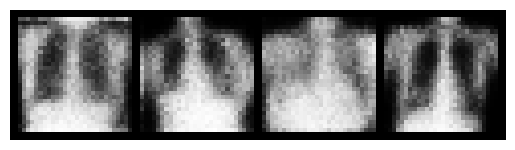

In [14]:
# Load and display generated images
img = plt.imread(f"/kaggle/working/wgan_epoch50.png")
plt.imshow(img)
plt.axis("off")
plt.show()

In [15]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

# Define the log directory
log_dir = "./runs/experiment_1"

# Start TensorBoard
notebook.start("--logdir " + log_dir)

%load_ext tensorboard
%tensorboard --logdir ./runs

!zip -r tensorboard_logs.zip ./runs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: runs/ (stored 0%)
  adding: runs/WGAN_training/ (stored 0%)
  adding: runs/WGAN_training/events.out.tfevents.1743778285.214e9e34f596.31.0 (deflated 64%)


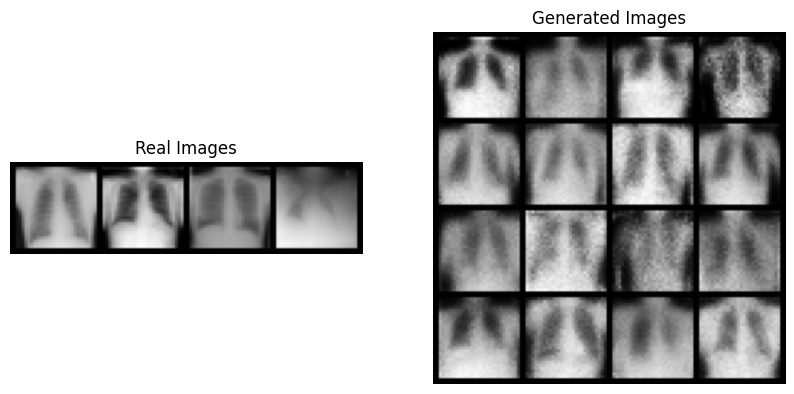

In [25]:
import torchvision.utils as vutils

# Function to show images
def show_images(real, fake, num_images=16):
    real = real[:num_images].cpu()
    fake = fake[:num_images].cpu()

    grid_real = vutils.make_grid(real, nrow=4, normalize=True)
    grid_fake = vutils.make_grid(fake, nrow=4, normalize=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(grid_real.permute(1, 2, 0))
    axes[0].set_title("Real Images")
    axes[0].axis("off")

    axes[1].imshow(grid_fake.permute(1, 2, 0))
    axes[1].set_title("Generated Images")
    axes[1].axis("off")

    plt.show()

# Show real vs generated images
show_images(real_images, fake_images)
